In [55]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import datetime as dt
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn.metrics import mean_squared_error
from xgboost import plot_importance, plot_tree
from statsmodels.tsa.seasonal import seasonal_decompose

# Загрузка данных

In [56]:
url_discounts_raw = 'https://raw.githubusercontent.com/beltelml/test/main/discounts_raw.csv'
discounts_raw = pd.read_csv(url_discounts_raw)

url_sales_raw = 'https://raw.githubusercontent.com/beltelml/test/main/sales_raw.csv'
sales_raw = pd.read_csv(url_sales_raw)

In [57]:
discounts_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2081 entries, 0 to 2080
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   item_id                  2081 non-null   int64  
 1   promo_typeCode           2041 non-null   float64
 2   sale_price_before_promo  2081 non-null   float64
 3   sale_price_time_promo    2081 non-null   float64
 4   date_start               2081 non-null   object 
 5   date_end                 2081 non-null   object 
dtypes: float64(3), int64(1), object(2)
memory usage: 97.7+ KB


In [58]:
sales_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147143 entries, 0 to 147142
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   date     147143 non-null  object 
 1   item_id  147143 non-null  int64  
 2   qnty     147143 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 3.4+ MB


In [59]:
discounts_raw

,item_id,promo_typeCode,sale_price_before_promo,sale_price_time_promo,date_start,date_end
0,100551,5.0,159.9,139.9,2023-03-02,2023-03-15
1,100553,5.0,159.9,139.9,2023-03-02,2023-03-15
2,100554,5.0,159.9,139.9,2023-03-02,2023-03-15
3,100558,5.0,159.9,139.9,2023-03-02,2023-03-15
4,100530,2.0,36.9,24.6,2021-09-09,2021-09-22
...,...,...,...,...,...,...
2076,100471,10.0,71.9,49.9,2023-05-25,2023-06-07
2077,100469,5.0,69.9,44.9,2023-11-07,2023-11-22
2078,100470,5.0,69.9,44.9,2023-11-07,2023-11-19
2079,100471,5.0,69.9,44.9,2023-11-07,2023-11-19


In [60]:
sales_raw

,date,item_id,qnty
0,2017-01-01,100001,7.0
1,2017-01-01,100003,2.0
2,2017-01-01,100006,13.0
3,2017-01-01,100010,5.0
4,2017-01-01,100035,53.0
...,...,...,...
147138,2023-12-31,100614,5.0
147139,2023-12-31,100140,4.0
147140,2023-12-31,100650,11.0
147141,2023-12-31,100182,1.0


# Получаем таблицу продаж за Декабрь 2023 года

In [61]:
pred_sales_raw = sales_raw[sales_raw['date'].where(sales_raw['date']>'2023-11-30').notna()]
pred_sales_raw['date'] = pd.to_datetime(pred_sales_raw['date'], format='%Y-%m-%d')

<ipython-input-61-64e85a9a0acb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_sales_raw['date'] = pd.to_datetime(pred_sales_raw['date'], format='%Y-%m-%d')


In [62]:
pred_sales_raw

,date,item_id,qnty
145170,2023-12-01,100545,3.0
145171,2023-12-01,100645,4.0
145172,2023-12-01,100683,1.0
145173,2023-12-01,100612,10.0
145174,2023-12-01,100165,15.0
...,...,...,...
147138,2023-12-31,100614,5.0
147139,2023-12-31,100140,4.0
147140,2023-12-31,100650,11.0
147141,2023-12-31,100182,1.0


# Выбор товаров на которые действуют акции в Декабре и Январе

Данная таблица нужна для актуальных цен за 2 месяца.
Из нее возьмем id товаров для таблицы на которые не действуют акции в Декабре и Январе, чтобы их удалить.

In [63]:
start_date = dt.datetime(2023,12,1)
end_date = dt.datetime(2024, 1, 31)

dates = pd.date_range(
    min(start_date, end_date),
    max(start_date, end_date)
).strftime('%Y-%m-%d').tolist()

day_of_week = []
for d in dates:
  year, month, day = (int(x) for x in d.split('-'))
  day_of_week.append(dt.date(year, month, day).weekday())

In [64]:
with_promo = discounts_raw[discounts_raw['date_end'].where((discounts_raw['date_end']>'2023-11-30') & (discounts_raw['date_end']<'2024-02-01')).notna()]

id_for_without_promo = list(set(with_promo['item_id'].to_numpy()))

In [65]:
pred_with_promo = with_promo.copy()
pred_with_promo['date'] = dates[0]
pred_with_promo['day_of_week'] = day_of_week[0]
for idx in range(1, len(dates)):
  temp_table = with_promo.copy()
  temp_table['date'] = dates[idx]
  temp_table['day_of_week'] = day_of_week[idx]
  pred_with_promo = pd.concat([pred_with_promo, temp_table])

In [66]:
pred_with_promo['promo_typeCode'] = pred_with_promo['promo_typeCode'].where((pred_with_promo['date_start'] <= pred_with_promo['date']) & (pred_with_promo['date'] <= pred_with_promo['date_end']), 0.0)

pred_with_promo['price'] = np.where(pred_with_promo['promo_typeCode'] == 0.0 , pred_with_promo['sale_price_before_promo'], pred_with_promo['sale_price_time_promo'])

pred_with_promo = pred_with_promo.drop(columns=['sale_price_before_promo','sale_price_time_promo','date_start','date_end'])
pred_with_promo = pred_with_promo.groupby(['item_id','date']).agg({"day_of_week":"first","price":"min","promo_typeCode":"max"}).reset_index()

pred_with_promo['date'] = pd.to_datetime(pred_with_promo['date'], format='%Y-%m-%d')

In [67]:
pred_with_promo

,item_id,date,day_of_week,price,promo_typeCode
0,100126,2023-12-01,4,449.9,0.0
1,100126,2023-12-02,5,449.9,0.0
2,100126,2023-12-03,6,449.9,0.0
3,100126,2023-12-04,0,449.9,0.0
4,100126,2023-12-05,1,449.9,0.0
...,...,...,...,...,...
3281,100691,2024-01-27,5,89.9,6.0
3282,100691,2024-01-28,6,89.9,6.0
3283,100691,2024-01-29,0,89.9,6.0
3284,100691,2024-01-30,1,89.9,6.0


# Выбор товаров на которые уже не действуют акции

В данной таблице товары на которые уже не будет акций

In [68]:
without_promo = discounts_raw[discounts_raw['date_end'].where(discounts_raw['date_end']<'2023-12-01').notna()]
without_promo = without_promo[~without_promo['item_id'].isin(id_for_without_promo)]

without_promo['promo_typeCode'] = 0.0

idx = without_promo.groupby('item_id')['date_end'].transform(max) == without_promo['date_end']
without_promo = without_promo[idx].drop(columns=['sale_price_time_promo','date_start','date_end']).rename(columns={"sale_price_before_promo": "price"})

without_promo = without_promo[~without_promo['item_id'].isin(id_for_without_promo)]

In [69]:
pred_without_promo = without_promo.copy()
pred_without_promo['date'] = dates[0]
pred_without_promo['day_of_week'] = day_of_week[0]
for idx in range(1, len(dates)):
  temp_table = without_promo.copy()
  temp_table['date'] = dates[idx]
  temp_table['day_of_week'] = day_of_week[idx]
  pred_without_promo = pd.concat([pred_without_promo, temp_table])

In [70]:
pred_without_promo['date'] = pd.to_datetime(pred_without_promo['date'], format='%Y-%m-%d')

In [71]:
pred_without_promo

,item_id,promo_typeCode,price,date,day_of_week
20,100399,0.0,239.9,2023-12-01,4
21,100455,0.0,119.9,2023-12-01,4
22,100464,0.0,75.9,2023-12-01,4
700,100245,0.0,64.9,2023-12-01,4
713,100547,0.0,189.9,2023-12-01,4
...,...,...,...,...,...
1922,100487,0.0,69.9,2024-01-31,2
1957,100184,0.0,99.9,2024-01-31,2
1967,100462,0.0,99.9,2024-01-31,2
2070,100225,0.0,140.0,2024-01-31,2


# Все данные за Декабрь

In [72]:
pred_discounts = pd.concat([pred_without_promo, pred_with_promo]).sort_values(by=['date'])

In [73]:
pred_discounts

,item_id,promo_typeCode,price,date,day_of_week
20,100399,0.0,239.9,2023-12-01,4
1736,100545,44.0,179.9,2023-12-01,4
1798,100551,0.0,149.9,2023-12-01,4
3224,100691,0.0,109.9,2023-12-01,4
1860,100596,0.0,126.9,2023-12-01,4
...,...,...,...,...,...
1611,100526,44.0,109.9,2024-01-31,2
1673,100528,44.0,109.9,2024-01-31,2
1735,100544,0.0,229.9,2024-01-31,2
1859,100551,0.0,149.9,2024-01-31,2


In [74]:
pred_discounts_december = pred_discounts[pred_discounts['date'].where(pred_discounts['date']<'2024-01-01').notna()]

sales_in_december = pd.merge(pred_sales_raw, pred_discounts_december, how='inner', left_on=['item_id','date'], right_on = ['item_id','date'])

In [75]:
sales_in_december

,date,item_id,qnty,promo_typeCode,price,day_of_week
0,2023-12-01,100545,3.0,44.0,179.9,4
1,2023-12-01,100645,4.0,0.0,154.9,4
2,2023-12-01,100683,1.0,0.0,239.9,4
3,2023-12-01,100612,10.0,0.0,46.9,4
4,2023-12-01,100165,15.0,0.0,63.9,4
...,...,...,...,...,...,...
1613,2023-12-31,100553,17.0,0.0,149.9,6
1614,2023-12-31,100614,5.0,0.0,37.9,6
1615,2023-12-31,100140,4.0,6.0,689.9,6
1616,2023-12-31,100650,11.0,5.0,79.9,6


Text(0, 0.5, 'Количество продаж')

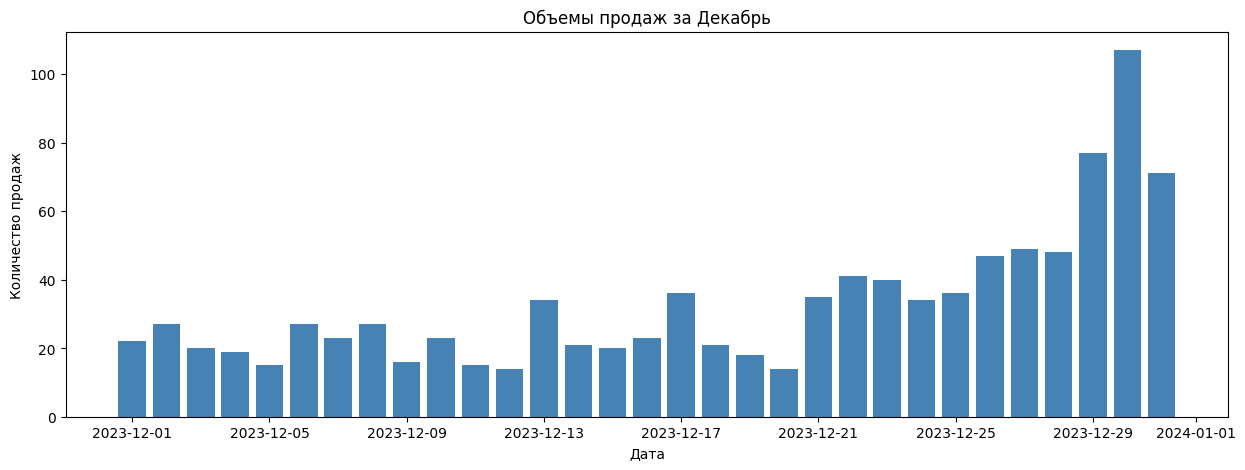

In [76]:
fig = plt.figure(figsize=(15,5))
axs = fig.add_subplot()
axs.bar(sales_in_december['date'],sales_in_december['qnty'],color='steelblue')
axs.set_title(u'Объемы продаж за Декабрь')
axs.set_xlabel('Дата')
axs.set_ylabel(u'Количество продаж')

Text(0.5, 1.0, 'Тренд и сезонность за Декабрь')

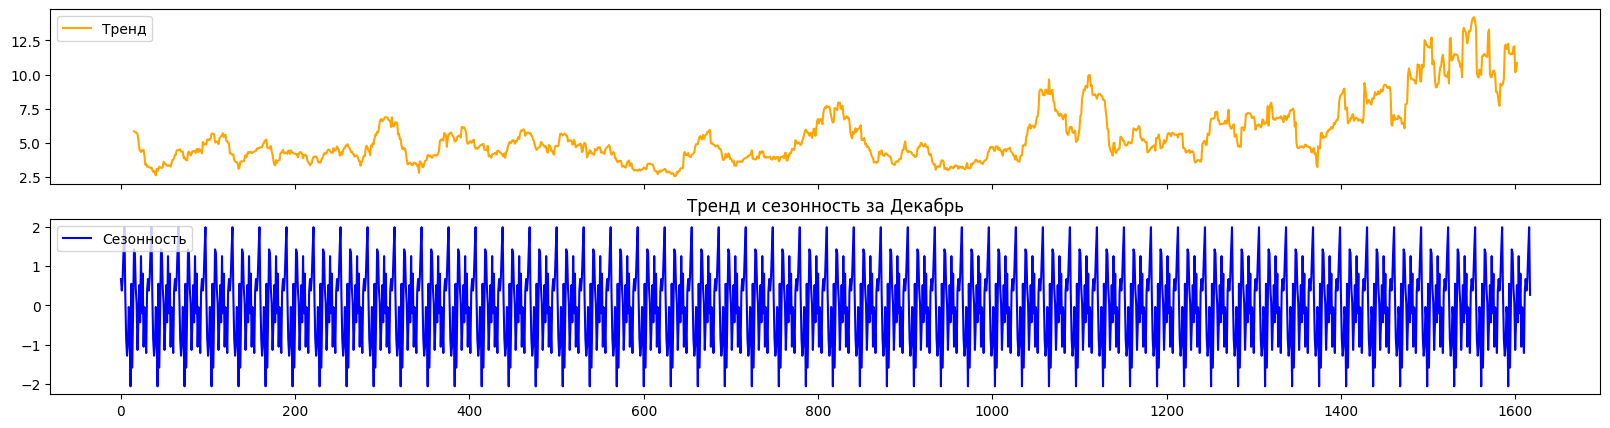

In [77]:
fig, ax = plt.subplots(2, 1, sharex=True, sharey=False)
fig.set_figheight(5)
fig.set_figwidth(20)

decomposition= seasonal_decompose(sales_in_december['qnty'], model='additive', period=31)

estimated_trend = decomposition.trend
estimated_seasonal = decomposition.seasonal
estimated_residual = decomposition.resid

ax[0].plot(estimated_trend, 'orange', label='Тренд')
ax[0].legend(loc='upper left');

ax[1].plot(estimated_seasonal, 'blue', label='Сезонность')
ax[1].legend(loc='upper left');

plt.title('Тренд и сезонность за Декабрь')

# Обучение модели регрессии XGBRegressor

In [78]:
sales_y = sales_in_december['qnty']
sales_X = sales_in_december.drop(['qnty','date'],axis=1)

In [79]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(sales_X, sales_y, test_size = 0.2)

model = xgb.XGBRegressor(n_estimators=1000)

model.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            early_stopping_rounds=50,
          verbose=False)

y_pred=model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


# Полученная среднеквадратичная ошибка

Количество единиц прогнозируемого товара может отличаться на данную величниу

In [80]:
print("Среднеквадратичная ошибка обучения модели (RMSE): %.2f" % mean_squared_error(y_test, y_pred, squared=False))

Среднеквадратичная ошибка обучения модели (RMSE): 6.92


# Данные для прогнозирования за Январь

In [81]:
pred_discounts_january = pred_discounts[pred_discounts['date'].where(pred_discounts['date']>'2023-12-31').notna()]
pred_discounts_january = pred_discounts_january.reset_index(drop=True)

discounts_X = pred_discounts_january.drop(['date'],axis=1)

# Предсказание модели

In [82]:
pred_january=model.predict(discounts_X)

# Поскольку мы прогнозируем количество продаж, то необходимо округлить полученные данные до целого числа, причем в меньшую сторону.

In [83]:
pred_january = [float(math.floor(n)) for n in pred_january]

sales_in_january = pred_discounts_january.drop(['price','promo_typeCode','day_of_week'],axis=1)

sales_in_january['qnty'] = pd.Series(pred_january)

sales_in_january = sales_in_january[['date', 'item_id', 'qnty']]

# Предсказанная таблица продаж на Январь 2024 года

In [84]:
sales_in_january

,date,item_id,qnty
0,2024-01-01,100516,5.0
1,2024-01-01,100528,3.0
2,2024-01-01,100454,1.0
3,2024-01-01,100399,2.0
4,2024-01-01,100612,7.0
...,...,...,...
2599,2024-01-31,100526,5.0
2600,2024-01-31,100528,5.0
2601,2024-01-31,100544,6.0
2602,2024-01-31,100551,2.0


Text(0, 0.5, 'Количество продаж')

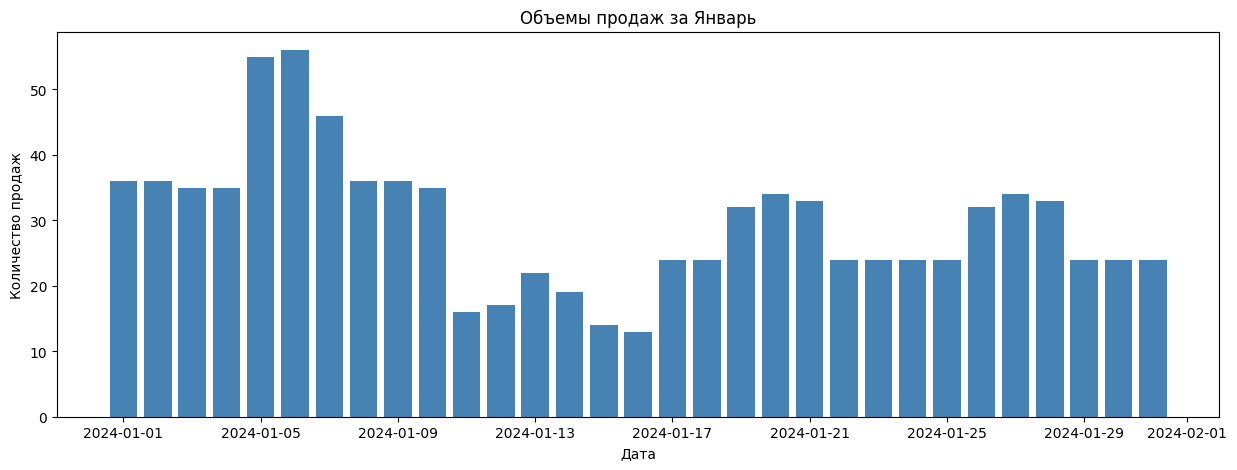

In [85]:
fig = plt.figure(figsize=(15,5))
axs = fig.add_subplot()
axs.bar(sales_in_january['date'],sales_in_january['qnty'],color='steelblue')
axs.set_title(u'Объемы продаж за Январь')
axs.set_xlabel('Дата')
axs.set_ylabel(u'Количество продаж')

Text(0.5, 1.0, 'Тренд и сезонность за Январь')

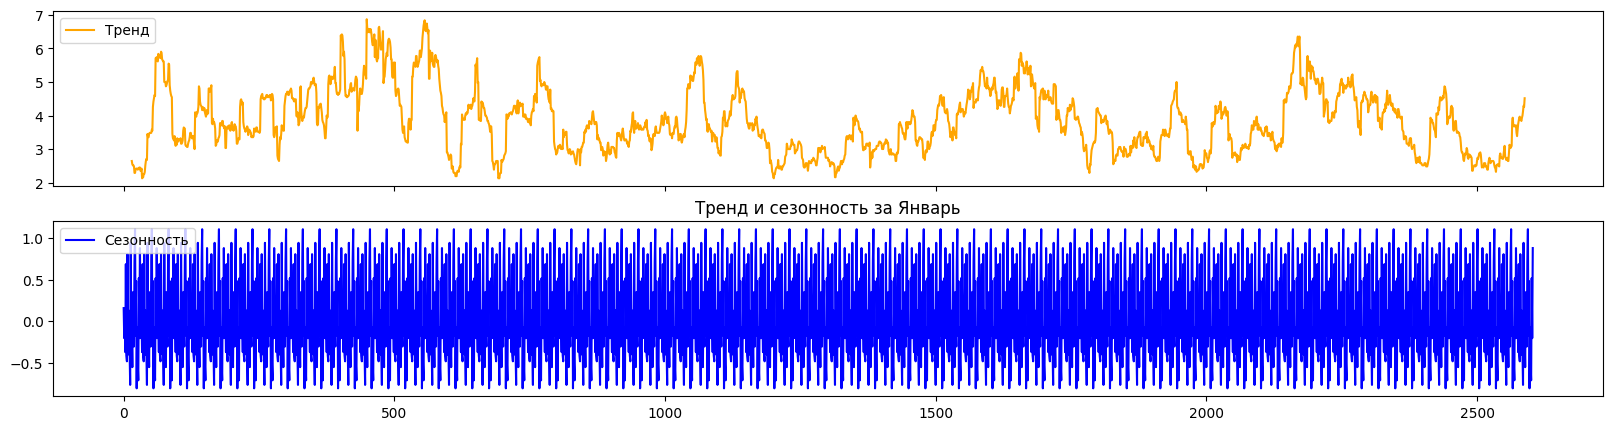

In [86]:
fig, ax = plt.subplots(2, 1, sharex=True, sharey=False)
fig.set_figheight(5)
fig.set_figwidth(20)

decomposition= seasonal_decompose(sales_in_january['qnty'], model='additive', period=31)

estimated_trend = decomposition.trend
estimated_seasonal = decomposition.seasonal
estimated_residual = decomposition.resid

ax[0].plot(estimated_trend, 'orange', label='Тренд')
ax[0].legend(loc='upper left');

ax[1].plot(estimated_seasonal, 'blue', label='Сезонность')
ax[1].legend(loc='upper left');

plt.title('Тренд и сезонность за Январь')

# Продажи за 2 месяца

In [87]:
sales_2_month = pd.concat([sales_in_december, sales_in_january]).drop(['promo_typeCode','price','day_of_week'],axis=1).reset_index(drop=True)

In [88]:
sales_2_month

,date,item_id,qnty
0,2023-12-01,100545,3.0
1,2023-12-01,100645,4.0
2,2023-12-01,100683,1.0
3,2023-12-01,100612,10.0
4,2023-12-01,100165,15.0
...,...,...,...
4217,2024-01-31,100526,5.0
4218,2024-01-31,100528,5.0
4219,2024-01-31,100544,6.0
4220,2024-01-31,100551,2.0


Text(0, 0.5, 'Количество продаж')

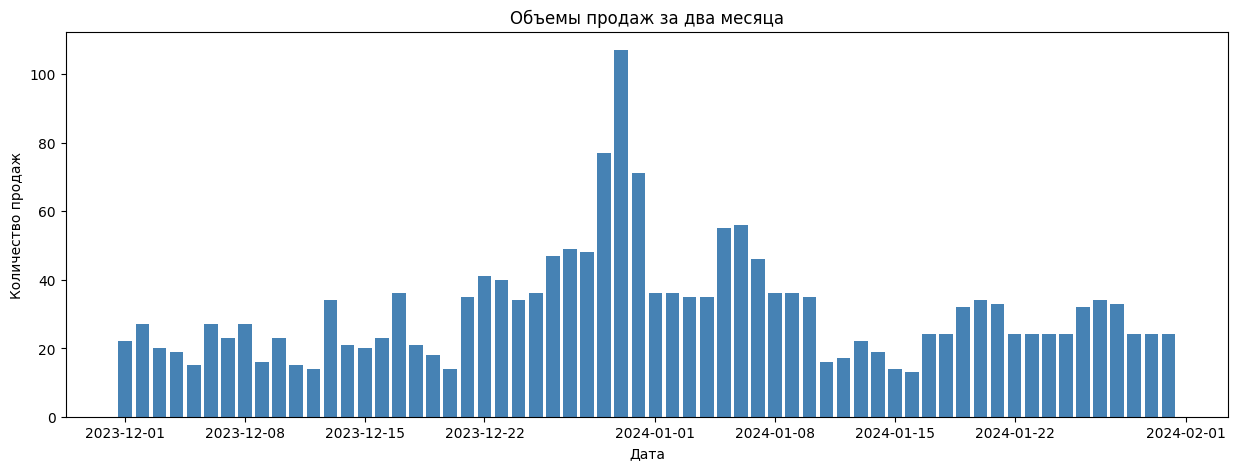

In [89]:
fig = plt.figure(figsize=(15,5))
axs = fig.add_subplot()
axs.bar(sales_2_month['date'],sales_2_month['qnty'],color='steelblue')
axs.set_title(u'Объемы продаж за два месяца')
axs.set_xlabel('Дата')
axs.set_ylabel(u'Количество продаж')

Text(0.5, 1.0, 'Тренд и сезонность за два месяца')

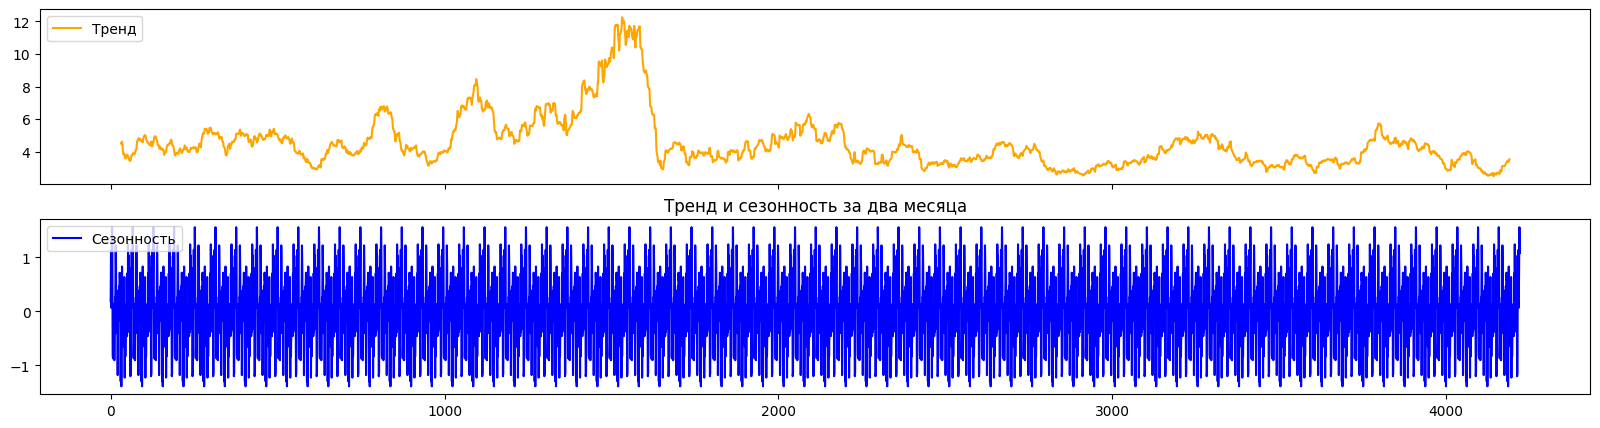

In [90]:
fig, ax = plt.subplots(2, 1, sharex=True, sharey=False)
fig.set_figheight(5)
fig.set_figwidth(20)

decomposition= seasonal_decompose(sales_2_month['qnty'], model='additive', period=62)

estimated_trend = decomposition.trend
estimated_seasonal = decomposition.seasonal
estimated_residual = decomposition.resid

ax[0].plot(estimated_trend, 'orange', label='Тренд')
ax[0].legend(loc='upper left');

ax[1].plot(estimated_seasonal, 'blue', label='Сезонность')
ax[1].legend(loc='upper left');

plt.title('Тренд и сезонность за два месяца')

# Выходные данные

In [91]:
sales_in_january.to_csv('sales_in_january.csv', index=False, sep=';')